In [1]:
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd
from knowledge_graph_generator import KnowledgeGraphGenerator
from fusion import TransE, TransEFuser, MovieKG

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler

In [8]:
full_df = pd.read_csv("data/kg_count_year_df.csv")
df = full_df.loc[(full_df["arc_count"] >= 500)&(full_df["year_released"] == 2017)].reset_index(
    drop=True
)
df = df[["entity_id", "relation", "value"]]
kg_obj = KnowledgeGraphGenerator(known_data_list=[df])
fuser = TransEFuser(kg_obj, max_epochs=10, n_splits=3, margin=2)
history = {}
kg_df = fuser.fuse(history=history)

relation is, epoch 0, loss 2.0209904114405313
relation is, epoch 1, loss 1.9729128082593281
relation is, epoch 2, loss 1.9652335246404011
relation is, epoch 3, loss 2.0178747177124023
relation is, epoch 4, loss 1.9412912925084431
relation is, epoch 5, loss 2.0196556051572165
relation is, epoch 6, loss 1.9776931603749592
relation is, epoch 7, loss 2.0009360313415527
relation is, epoch 8, loss 1.9561313390731812
relation is, epoch 9, loss 1.9639172355333965
relation is, epoch 0, loss 1.9111463626225789
relation is, epoch 1, loss 1.9467897812525432
relation is, epoch 2, loss 2.0045174956321716
relation is, epoch 3, loss 1.9797898332277934
relation is, epoch 4, loss 2.0206111073493958
relation is, epoch 5, loss 1.9863604108492534
relation is, epoch 6, loss 1.9907623330752056
relation is, epoch 7, loss 1.9677425026893616
relation is, epoch 8, loss 1.992995262145996
relation is, epoch 9, loss 2.063558598359426
relation is, epoch 0, loss 1.973839779694875
relation is, epoch 1, loss 1.95945771

In [9]:
history

{0: {'training_loss': [1.9011509418487549,
   2.0025622844696045,
   1.9024423360824585,
   1.8977711200714111,
   1.8088229894638062,
   1.9104039669036865,
   1.9300634860992432,
   2.0594258308410645,
   1.5045044422149658,
   1.9066190719604492],
  'test_loss': [1.9032872915267944,
   1.937565565109253,
   1.9821113348007202,
   1.8303961753845215,
   1.8260068893432617,
   1.9872126579284668,
   2.065155506134033,
   2.10807204246521,
   1.9667805433273315,
   1.9509228467941284]},
 1: {'training_loss': [2.1440131664276123,
   1.8530921936035156,
   1.9076646566390991,
   1.924023985862732,
   1.7212610244750977,
   1.642584204673767,
   1.9489872455596924,
   1.595483660697937,
   2.0414481163024902,
   1.9179112911224365],
  'test_loss': [2.025085926055908,
   1.4156317710876465,
   1.943536639213562,
   1.3716404438018799,
   2.022490978240967,
   1.429726004600525,
   1.2684839963912964,
   1.253208875656128,
   1.4030966758728027,
   2.1244866847991943]},
 2: {'training_loss'

In [10]:
movie_data = pd.read_csv("raw_data/movie_data.csv")
movie_data.rename(columns={"rotten_tomatoes_link":"entity_id"}, inplace=True)
m = movie_data[["entity_id", "tomatometer_rating"]].drop_duplicates()
kg_df = kg_df.merge(m, on="entity_id")

In [11]:
kg_df[(kg_df["relation"] == "is")&(kg_df["value"] == "good")].sort_values("probability")

,entity_id,relation,value,distance,probability,tomatometer_rating
375271,m/sunset_boulevard,is,good,2.650977,0.000000,99.0
417293,m/the_unspeakable_act_2012,is,good,2.639251,0.013572,89.0
438957,m/velvet_goldmine,is,good,2.619537,0.036389,57.0
425182,m/to_wong_foo_thanks_for_everything_julie_newmar,is,good,2.612651,0.044360,39.0
452165,m/wild_target,is,good,2.588689,0.072093,33.0
...,...,...,...,...,...,...
394431,m/the_expendables,is,good,1.820389,0.961342,42.0
124011,m/chicken_run,is,good,1.811299,0.971863,97.0
279595,m/mixed_nuts,is,good,1.799881,0.985079,10.0
53768,m/1212910-warrior,is,good,1.798843,0.986280,83.0


In [ ]:
transe = TransE(kg_obj)

count_limit_250_df = pd.read_csv("data/count_limit_250.csv")

In [3]:
count_limit_100_df = pd.read_csv("data/count_limit_100.csv")

In [7]:
kg_obj = KnowledgeGraphGenerator(known_data_list = [count_limit_100_df[["entity_id", "relation", "value"]]])
transe = TransE(kg_obj)

In [39]:
c[count_limit_100_df.columns].to_csv("data/count_limit_100.csv", index=False)

In [36]:
c = count_limit_100_df.copy(deep=True)
g = count_limit_100_df[["relation", "value", "distance"]].groupby(["relation", "value"])

In [37]:
c = c.merge(g.min().reset_index().rename(columns={"distance": "min_distance"}), on=["relation", "value"])
c = c.merge(g.max().reset_index().rename(columns={"distance": "max_distance"}), on=["relation", "value"])
c["probability"] = 1 - (c["distance"] - c["min_distance"])/(c["max_distance"] - c["min_distance"])

In [38]:
c[(c["relation"] == "is")&(c["value"] == "good")].sort_values("probability")

,entity_id,relation,value,distance,probability,min_distance,max_distance
5238,m/gay_divorcee,is,good,5.490583,0.000000,3.561836,5.490583
6856,m/lootera,is,good,5.481771,0.004568,3.561836,5.490583
6772,m/mating_habits_of_the_earthbound_human,is,good,5.467676,0.011877,3.561836,5.490583
5304,m/into_the_night,is,good,5.465469,0.013021,3.561836,5.490583
6308,m/passenger_57,is,good,5.465423,0.013045,3.561836,5.490583
...,...,...,...,...,...,...,...
2117,m/ghost_in_the_shell_2017,is,good,3.568491,0.996549,3.561836,5.490583
2873,m/mad_max_fury_road,is,good,3.567918,0.996847,3.561836,5.490583
1825,m/dunkirk_2017,is,good,3.565719,0.997987,3.561836,5.490583
2507,m/inside_out_2015,is,good,3.565609,0.998044,3.561836,5.490583


In [10]:
for relation in count_limit_250_df["relation"].unique():
    for value in tqdm(count_limit_250_df[count_limit_250_df["relation"] == relation]["value"].unique()):
        d = count_limit_250_df[(count_limit_250_df["relation"] == relation)&(count_limit_250_df["value"] == value)]["distance"]
        scaler = MinMaxScaler()
        p = scaler.fit_transform(d.values.reshape(-1, 1))
        count_limit_250_df.loc[(count_limit_250_df["relation"] == relation)&(count_limit_250_df["value"] == value), "probability"]

KeyboardInterrupt: 

In [3]:
r = df.loc[df["relation"] == kg_obj.relations[0]]
idx_array = transe.gen_training_array(r)
transe.gen_random_dist(idx_array)
d = count_limit_250_df[count_limit_250_df["relation"] == kg_obj.relations[0]]["distance"]
p = transe.gen_probability(d)

In [3]:
df = full_df.loc[full_df["arc_count"] >= 250].reset_index(
    drop=True
)

In [9]:
count_limit_250_df = pd.read_csv("data/count_limit_250.csv")

In [4]:
d = df.loc[(df["relation"] == "is")]["distance"].values
p = df.loc[(df["relation"] == "is")]["probability"].values

In [5]:
np.max(p)

0.9786944933259916

In [25]:
sns.scatterplot(d, p)

C:\Users\TomPace\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

In [2]:
df = pd.read_csv("data/kg_count_year_df.csv")
# df = df.loc[(df["year_released"] == 2017)&(df["arc_count"] >= 500)].reset_index(drop=True)
# toy = df.loc[(df["year_released"] == 2017)&(df["arc_count"] >= 25)]
toy = df.loc[(df["arc_count"] >= 250)]
toy = toy[["entity_id", "relation", "value"]]

# kg_obj = KnowledgeGraphGenerator(known_data_list=[toy])
# fuser = TransEFuser(kg_obj, max_epochs=1, batch_size=1024)

In [13]:
full_df[full_df["value"] == "homoerotic"]

,entity_id,relation,value,year_released,arc_count
1299004,m/10010667-hangover,is,homoerotic,2009,40
1299005,m/10011016-messenger,is,homoerotic,2009,40
1299006,m/1107198-driven,is,homoerotic,2001,40
1299007,m/1112357-scoobydoo,is,homoerotic,2002,40
1299008,m/1151898-capote,is,homoerotic,2005,40
1299009,m/1191620-college,is,homoerotic,2008,40
1299010,m/22_jump_street,is,homoerotic,2014,40
1299011,m/300_rise_of_an_empire,is,homoerotic,2014,40
1299012,m/a_nightmare_on_elm_street_2_freddys_revenge,is,homoerotic,1985,40
1299013,m/american_wedding,is,homoerotic,2003,40


In [2]:
movie_data = pd.read_csv("raw_data/movie_data.csv")
# kg_df = pd.read_csv("data/count_limit_100.csv")
movie_data.rename(columns={"rotten_tomatoes_link":"entity_id"}, inplace=True)

In [19]:
movie_data.columns
#["tomatometer_fresh_critics_count"]/movie_data["tomatometer_top_critics_count"]

Index(['entity_id', 'Title', 'movie_info', 'critics_consensus',
       'content_rating', 'genres', 'directors', 'authors', 'actors',
       'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'Release Year', 'Origin/Ethnicity', 'Wiki Page', 'Plot'],
      dtype='object')

In [5]:
df = kg_df.merge(movie_data[["entity_id", "tomatometer_rating"]].drop_duplicates(), on="entity_id")

In [83]:
from difflib import get_close_matches
get_close_matches("shark", kg_df["value"].unique())

['stark', 'sharp', 'shaky']

In [78]:
t = kg_df[(kg_df["value"] == "war")]
t.sort_values("probability")

,entity_id,relation,value,distance,probability
5414686,m/silver_chalice,is,war,5.094918,0.000000
12624345,m/that_old_feeling,features the theme,war,2.584547,0.000000
5410589,m/grey_owl,is,war,5.091775,0.001619
5415271,m/kull_the_conqueror,is,war,5.091332,0.001847
5413603,m/gay_divorcee,is,war,5.091193,0.001919
...,...,...,...,...,...
12622370,m/wind_river_2017,features the theme,war,0.908825,0.999534
5410238,m/enders-game,is,war,3.154288,0.999625
5413046,m/war_for_the_planet_of_the_apes,is,war,3.154174,0.999684
12618369,m/1205377-last_house_on_the_left,features the theme,war,0.908043,1.000000


In [56]:
d = df.loc[df["entity_id"] == "m/top_gun"].reset_index(drop=True)
for i in range(len(d)):
    r = d.iloc[i]
    print(r["relation"], r["value"])

heme touch
features the theme families
features the theme the ages
features the theme the dark
features the theme the scenes
features the theme his cast
features the theme a boy
features the theme the animation
features the theme the desert
features the theme the station
features the theme its own terms
features the theme the fire
features the theme honor
features the theme the hero
features the theme father
features the theme the suspense
features the theme mood
features the theme the actor
features the theme its cast
features the theme a joke
features the theme more time
features the theme the entire film
features the theme the concept
features the theme her room
features the theme star
features the theme a success
features the theme the church
features the theme those movies
features the theme its stars
features the theme the action scenes
features the theme heroes
features the theme chase
features the theme a franchise
features the theme the roof
features the theme the original fil

<AxesSubplot:xlabel='tomatometer_rating', ylabel='probability'>

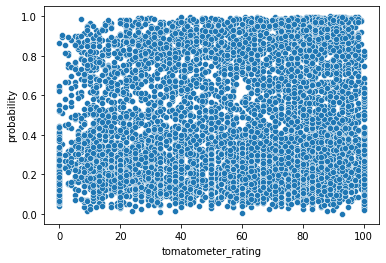

In [9]:
sns.scatterplot(x=t["tomatometer_rating"], y=t["probability"])

In [39]:
np.random.choice(movie_data["entity_id"].unique(), size=10)

array(['m/the_man_from_planet_x',
       'm/free_willy_2_the_adventure_home_1995',
       'm/theres_something_about_mary', 'm/life_before_her_eyes',
       'm/find_me_guilty', 'm/mouse_that_roared', 'm/amityville_horror',
       'm/houseguest', 'm/1006207-dr_jekyll_and_mr_hyde',
       'm/bruce_almighty'], dtype=object)

In [25]:
movie_data[movie_data["entity_id"] == "m/wild_things"]

,entity_id,Title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,Release Year,Origin/Ethnicity,Wiki Page,Plot
7017,m/wild_things,Wild Things,When teen debutante Kelly (Denise Richards) fa...,"Wild Things is a delightfully salacious, flesh...",R,"Comedy, Drama, Mystery & Suspense",John McNaughton,"John McNaughton, Stephen Peters","Matt Dillon, Denise Richards, Neve Campbell, K...",1998-03-20,...,Spilled,53.0,93016.0,19,38,23,1998,American,https://en.wikipedia.org/wiki/Wild_Things_(film),A popular Miami area high school guidance coun...


In [40]:
movie_list = [
    "m/terminator_2_judgment_day",
    "m/demolition_man",
    "m/lethal_weapon",
    "m/top_gun",
    "m/dumb_and_dumber",
    "m/hot_tub_time_machine",
    "m/robin_hood_men_in_tights",
    "m/crocodile_dundee",
    "m/spaceballs",
    "m/theres_something_about_mary",
]

In [41]:
df = pd.read_csv("data/review_plot_df.csv")

In [44]:
df = df.loc[df["entity_id"].isin(movie_list)].reset_index(drop=True)

In [45]:
kg_obj = KnowledgeGraphGenerator(input_data_list=[df])

In [48]:
kg_obj.knowledge_graph_df.to_csv("data/small_kg_df.csv")

In [49]:
fuser = TransEFuser(kg_obj, batch_size=64)
kg_df = fuser.fuse()

relation features the theme, epoch 0, loss 1.002860203385353
relation features the theme, epoch 1, loss 0.9845772609114647
relation features the theme, epoch 2, loss 1.029191941022873
relation features the theme, epoch 3, loss 1.0601726099848747
relation features the theme, epoch 4, loss 1.0038696601986885
relation features the theme, epoch 5, loss 1.04451634734869
relation features the theme, epoch 6, loss 0.8814599961042404
relation features the theme, epoch 7, loss 1.0523205772042274
relation features the theme, epoch 8, loss 0.9097628518939018
relation features the theme, epoch 9, loss 1.0381921827793121
relation features the theme, epoch 0, loss 0.7824704945087433
relation features the theme, epoch 1, loss 0.7565734833478928
relation features the theme, epoch 2, loss 0.7327149733901024
relation features the theme, epoch 3, loss 0.7852549478411674
relation features the theme, epoch 4, loss 0.6693100593984127
relation features the theme, epoch 5, loss 0.8057362511754036
relation fea

In [62]:
group_df = kg_df[["entity_id", "relation", "value", "distance"]].groupby(
    ["entity_id", "relation", "value"]
)
kg_df = kg_df.merge(
            group_df.mean()
            .reset_index()
            .rename(columns={"distance": "mean_distance"}),
            on=["entity_id", "relation", "value"],
        )

In [63]:
t = kg_df[["entity_id", "relation", "value", "mean_distance"]].drop_duplicates()

In [71]:
v = t[t["value"] == "good"].sort_values("mean_distance")

In [66]:
r = movie_data[["entity_id", "audience_rating", "tomatometer_rating"]].drop_duplicates()

In [67]:
t = t.merge(r, on="entity_id")

In [76]:
d = pd.read_csv("data/count_limit_25.csv")

In [91]:
d[d["value"] == "World War II"].sort_values("distance").iloc[:20]

,entity_id,relation,value,distance,probability
1347541,m/inglourious_basterds,features the miscellaneous theme,World War II,0.423227,0.994289
1347493,m/captain_america_the_first_avenger,features the miscellaneous theme,World War II,0.548389,0.989281
1347463,m/1108389-pearl_harbor,features the miscellaneous theme,World War II,0.572730,0.987952
1347543,m/inside_out_2015,features the miscellaneous theme,World War II,0.572944,0.987939
1347529,m/fury_2015,features the miscellaneous theme,World War II,0.602335,0.986144
1347503,m/curious_case_of_benjamin_button,features the miscellaneous theme,World War II,0.607101,0.985832
1347584,m/pacific_rim_2013,features the miscellaneous theme,World War II,0.623664,0.984701
1347474,m/allied,features the miscellaneous theme,World War II,0.624639,0.984632
1347617,m/the_monuments_men,features the miscellaneous theme,World War II,0.630483,0.984213
1347615,m/the_master_2011,features the miscellaneous theme,World War II,0.639391,0.983556


In [92]:
# science fiction
sci_fi = 0.9
# World War II
wwII = 0.8
# zombies
zombies = 0.6
# murder
murder = 0.8
# marijuana
mj = 0.8
# Jack Black
JB = 0.9
# HBO
HBO = 0.4
# neighbors
neighbors = 0.5
# Ireland
ireland = 0.8
# funny
funny = 0.1 
# dragon
dragon = 0.6
# rivalry
rivalry = 0.9
# another planet
another_planet = 0.4
# a beautiufl woman
beaut_woman = 0.9
# a bank robbery
bank = 0.9
# a time machine
time = 0.5
# horses
horses = 0.9
# graduation
grad = 1
# a musical number
music = 0.9
# immortality
immortal = 0.6

In [102]:
relevance = [
    sci_fi, 
    wwII, 
    zombies, 
    murder, 
    mj, 
    JB, 
    HBO, 
    neighbors, 
    ireland, 
    funny,
    dragon, 
    rivalry, 
    another_planet, 
    beaut_woman, 
    bank, 
    time,
    horses, 
    grad, 
    music, 
    immortal    
]

value = [
    "science fiction",
    "World War II",
    "zombies",
    "murder",
    "marijuana",
    "Jack Black",
    "HBO",
    "neighbors",
    "Ireland",
    "funny",
    "dragon",
    "rivalry",
    "another planet",
    "beautiful woman",
    "bank",
    "time machine",
    "horses",
    "graduation",
    "musical",
    "immortal"
]


In [94]:
tips = sns.load_dataset("tips")

In [107]:
t = pd.DataFrame(columns=["Value", "Relevance"])
t["Value"] = value
t["Relevance"] = relevance

Text(0.5, 1.0, 'Relevance for randomly selected values.')

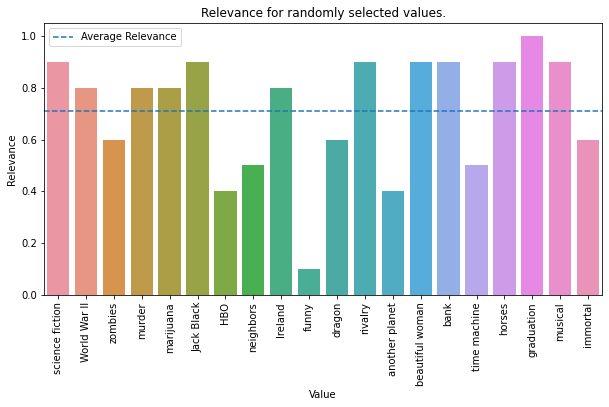

In [116]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Value", y="Relevance", data=t)
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.axhline(0.71, ls='--', label="Average Relevance")
plt.legend()
plt.title("Relevance for randomly selected values.")

In [110]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',